In [1]:
# -*- coding: utf-8 -*-

# raspagem de estoque e ocupação de leitos
import os
import requests
import pandas as pd
import camelot
import numpy as np
from datetime import datetime
from datetime import date
from IPython.display import display


def getTableLimits(file):
    import fitz
    doc = fitz.open(file)
    for page in doc:
        s = page.searchFor('LEITOS HOSPITALARES SUS\n'
                           + 'EXCLUSIVOS PARA PACIENTES SUSPEITOS OU\n'
                           + 'CONFIRMADOS COVID-19 POR MACRORREGIÃO')
        if s:
            start = page.number + 1
    try:
        return(start)
    except:
        raise NameError('Page not found')


def readleitos(file, pages):
    tables = camelot.read_pdf(file, pages=pages)
    return(tables[1].df)


def convertBoletim(df):
    df.loc[0] = df.loc[0].replace('', None)
    df.loc[1] = df.loc[1].replace('', None)
    df2 = df.T
    df2.loc[0][0:3] = ['tipo_idade', 'tipo_leito', 'metrica']
    df2.columns = df2.iloc[0]
    df2 = df2.drop(df2.index[0])
    df2 = df2.rename(columns = {'NOROES\nTE':'NOROESTE'})

    a = df2.metrica
    b = pd.Series(np.resize(['','Exist. Ocup. Livres','','Tx de \nocup.'],16), name='metrica')
#     if all(a.values == b.values):
    if 1==1:
        df2.metrica = np.resize(['estoque_leitos','ocupados','livres','tx_ocupacao'],16)
        df2.columns = ['tipo_idade', 'tipo_leito', 'metrica', 'LESTE','OESTE','NOROESTE','NORTE','TOTAL']
        df3 = df2.melt(id_vars=['tipo_idade', 'tipo_leito','metrica']
                       , value_vars=['LESTE','OESTE','NOROESTE','NORTE','TOTAL']
                       , var_name='territorio')  
        df3 = df3[~df3['metrica'].isin(['livres','tx_ocupacao'])]
        df3 = df3.assign(data = pd.to_datetime(reportdate, format='%d%m%Y')
                         , escopo = df3.territorio.apply(lambda x: 'estadual' if x == 'TOTAL' else 'regional'))
        df3.tipo_idade = df3.tipo_idade.apply(lambda x: x.capitalize())
        df3.territorio = df3.territorio.apply(lambda x: x.capitalize()).replace('Total', 'Paraná')
        df3.tipo_leito = df3.tipo_leito.replace('ENFERMARIA', 'Enfermaria')
        df3.value = df3.value.replace('',0).replace('-',0).replace(regex=r'([0-9]{1,}).([0-9]{3})'
          , value='\\1\\2').apply(pd.to_numeric, errors='coerce', downcast='unsigned')
        df4 = df3.pivot_table(index = ['data', 'escopo', 'territorio', 'tipo_idade','tipo_leito', ]
                          , columns = 'metrica', values='value')
        df4 = df4.assign(obs = '')
        return(df4)
    else:
        print("Wrong Headers!") 
        print(a.values)
        print(b.values)


def joinleitos(boletim_df):
    backdf = pd.read_csv('../leitospr.csv', sep=',', parse_dates = ['data'])
    if boletim_df.index.unique(level='data').isin(backdf['data']).all():
        print('Already inn')
    else:
        reportdate = boletim_df.index.unique(level='data')[0].strftime('%d%m%Y')
        print(f'Adding {reportdate}')
        indexescope = ['data', 'escopo', 'territorio', 'tipo_idade', 'tipo_leito']
        indexdf = pd.MultiIndex.from_frame(backdf[indexescope])
        backdf = backdf.set_index(indexdf).drop([
            'data','escopo','territorio','tipo_idade','tipo_leito'], axis = 1)
        joined = backdf.append(boletim_df)
        return(joined)

def showLeitos(file, pageNum):
    from IPython.display import Image
    import fitz, re, pandas as pd, numpy as np
    doc = fitz.open(file)
    page = doc.loadPage(pageNum-1)
    pix = page.getPixmap(clip = [5, 502, 591, 740])
    pix.writeImage('latest.png')
    return(Image(filename='latest.png'))

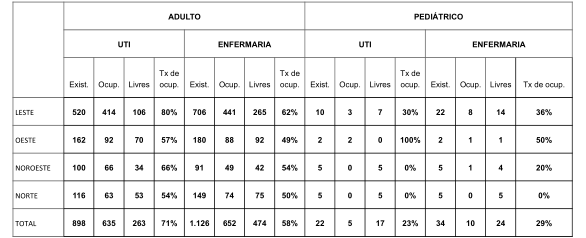

metrica                                               estoque_leitos  \
data       escopo   territorio tipo_idade tipo_leito                   
2020-11-17 estadual Paraná     Adulto     Enfermaria            1126   
                                          UTI                    898   
                               Pediátrico Enfermaria              34   
                                          UTI                     22   
           regional Leste      Adulto     Enfermaria             706   
                                          UTI                    520   
                               Pediátrico Enfermaria              22   
                                          UTI                     10   
                    Noroeste   Adulto     Enfermaria              91   
                                          UTI                    100   
                               Pediátrico Enfermaria               5   
                                          UTI                      5   
                    Norte      Adulto     Enfermaria             149   
                                          UTI                    116   
                               Pediátrico Enfermaria               5   
                                          UTI                      5   
                    Oeste      Adulto     Enfermaria             180   
                                          UTI                    162   
                               Pediátrico Enfermaria               2   
                                          UTI                      2   

metrica                                               ocupados obs  
data       escopo   territorio tipo_idade tipo_leito                
2020-11-17 estadual Paraná     Adulto     Enfermaria       652      
                                          UTI              635      
                               Pediátrico Enfermaria        10      
                                          UTI                5      
           regional Leste      Adulto     Enfermaria       441      
                                          UTI              414      
                               Pediátrico Enfermaria         8      
                                          UTI                3      
                    Noroeste   Adulto     Enfermaria        49      
                                          UTI               66      
                               Pediátrico Enfermaria         1      
                                          UTI                0      
                    Norte      Adulto     Enfermaria        74      
                                          UTI               63      
                               Pediátrico Enfermaria         0      
                                          UTI                0      
                    Oeste      Adulto     Enfermaria        88      
                                          UTI               92      
                               Pediátrico Enfermaria         1      
                                          UTI                2

Adding 17112020


In [2]:
reportdate = date.today().strftime("%d%m%Y")
# reportdate = '13112020'
date_boletim = reportdate[0:2] + '_' + reportdate[2:4] + '_' + reportdate[4:]
page = getTableLimits(f'../boletins/informe_{reportdate}.pdf')
raw_df = readleitos(f'../boletins/informe_{reportdate}.pdf', str(page))
boletim_df = convertBoletim(raw_df)
display(showLeitos(f'../boletins/informe_{reportdate}.pdf', page))
display(boletim_df)
all_joined = joinleitos(boletim_df)

In [3]:
all_joined.to_csv('../leitospr.csv', float_format="%.0f")
os.remove('latest.png')
print(f'{reportdate} Done!')

17112020 Done!
